# Fundamentos de la Computación Cuántica - Segunda Entrega

A lo largo de la _notebook_, se resuelven los ejercicios solicitados por la cátedra de la materia optativa Fundamentos de la Computación Cuántica como segunda entrega de la cursada. Estos son:

a. Ejercicio 10 del TP de Operaciones (Parte I).

b. Ejemplo 1 del ejercicio 1 del TP de Paralelismo Cuántico (Deutsch-Jozsa, función constante igual a 1).

c. Ejemplo 3 del ejercicio 1 del TP de Paralelismo Cuántico (Deutsch-Jozsa, función balanceada).

d. Ejemplo 4 del ejercicio 1 del TP de Paralelismo Cuántico (Deutsch-Jozsa, función **no** balanceada **ni** constante).

Para ello, se utiliza el _framework_ Qiskit.

## Imports

Previo a la resolución de los ejercicios, se realizan las importaciones de las librerías necesarias:

In [31]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

Con las importaciones requeridas realizadas, se prosigue con la resolución de los ejercicios indicados.

## A) Full-Adder con Operandos de 4 Qubits

Corresponde al ejercicio 10 del TP de operaciones (parte I), cuya consigna es la siguiente:

_Basándose en el ejercicio 9, implemente en el simulador un sumador completo entre dos operandos de tamaño 4 qubits. Utilice subcircuitos._

Para ello, debe resolverse primero el ejercicio 9 en Qiskit, cuya consigna es:

_Implemente un sumador completo con operandos de un qubit (enfoque clásico) basándose en computación reversible clásica, mediante el uso de compuertas C-NOT y Toffoli (CC-NOT). Utilice el simulador._

### Full-Adder

A continuación, se realiza el planteo del circuito:

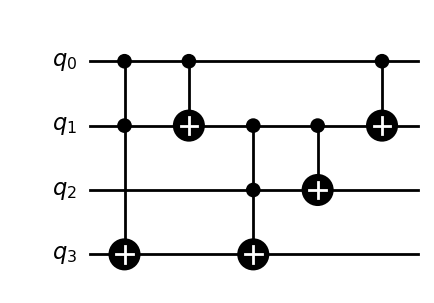

In [32]:
# Definición del circuito cuántico.
full_adder = QuantumCircuit(4, name="Full-Adder");

# Agregado de compuertas.
full_adder.ccx(0, 1, 3)
full_adder.cx(0, 1)
full_adder.ccx(1, 2, 3)
full_adder.cx(1, 2)
full_adder.cx(0, 1)

# Dibujado.
full_adder.draw(output='mpl', style='bw')

Para corroborar que funcione correctamente, se le añaden medidores, de forma que luego puedan corroborarse sus resultados mediante una simulación:

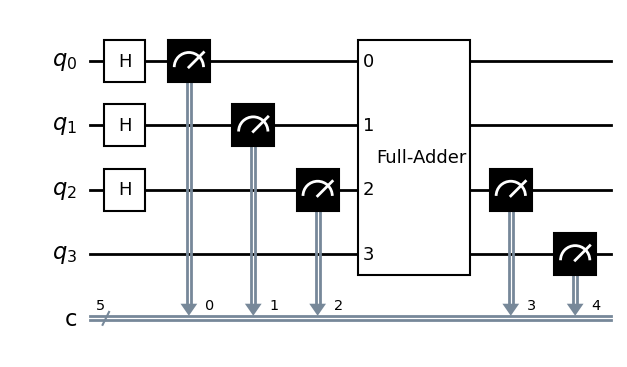

In [33]:
# c[0]: Entrada A (q0).
# c[1]: Entrada B (q1).
# c[2]: Entrada Cin (q2).
# c[3]: Salida S (q2).
# c[4]: Salida Cout (q3).
full_adder_measured = QuantumCircuit(4, 5) 

# Se colocan las entradas en superposición.
# Esto con la finalidad de probar todas las
# posibilidades.
full_adder_measured.h([0, 1, 2])

# Medición de las entradas (A, B y Cin) en bits 0, 1 y 2, respectivamente.
full_adder_measured.measure(0, 0)
full_adder_measured.measure(1, 1)
full_adder_measured.measure(2, 2)

# Aplicación de la compuerta FA.
full_adder_measured.append(full_adder, [0, 1, 2, 3])

# Medición de las salidas (S y Cout) en bits 3 y 4, respectivamente.
full_adder_measured.measure(2, 3)
full_adder_measured.measure(3, 4)

# Comprobación gráfica del circuito.
full_adder_measured.draw(output='mpl', style='bw')

Con las mediciones añadidas, se realiza una simulación y se muestran los resultados mediante un histograma:

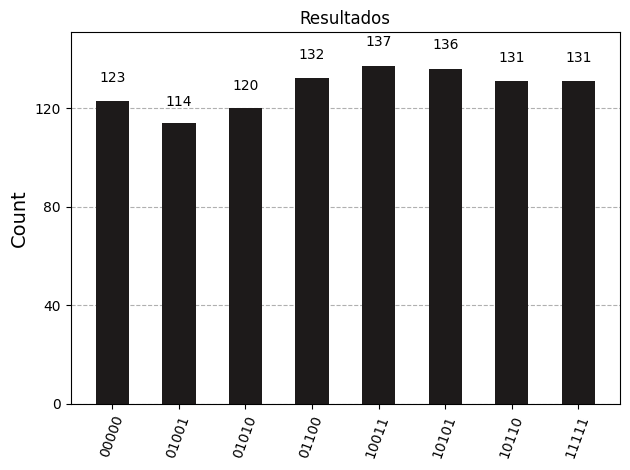

In [34]:
simulator = AerSimulator()
transpiled = transpile(full_adder_measured, simulator)
job = simulator.run(transpiled, shots=1024)
results = job.result()
counts = results.get_counts(transpiled)

plot_histogram(counts, title="Resultados", color="#1D1A1A")

Como puede observarse, un histograma no es la mejor forma de mostrar el correcto funcionamiento del circuito. Este se adjunta ya que forma parte del enunciado de la entrega. Sin embargo, se consideró más apropiado para este inciso mostrar los resultados mediante una tabla. Esta no solo facilita la lectura del bitstring devuelto por el simulador, sino que, además, indica si el resultado obtenido es correcto, calculando, para ello, con los operadores de bits de Python, la salida esperada: 

In [35]:
# Definición de anchos de columna para consistencia.
W_QUBITS = 5  # Ancho para A, B, Cin, S y Cout.
W_COUNT = 15 # Ancho para Frecuencia.
W_CORRECT = 10 # Ancho de la correctitud del resultado.
TOTAL_WIDTH = W_QUBITS * 5 + W_COUNT + W_CORRECT + 22 # 8 barras y 14 espacios adicionales.

# Separador
def print_separator(width):
    print(f"|{'-' * (width - 2)}|") # -2 por las barras.

# Título
print_separator(TOTAL_WIDTH)
print(f"|{'Tabla de Verdad Experimental del Full-Adder':^{TOTAL_WIDTH - 2}}|") # -2 por las barras.
print_separator(TOTAL_WIDTH)

# Encabezados
print(f"| {'A':^{W_QUBITS}} | {'B':^{W_QUBITS}} | {'Cin':^{W_QUBITS}} | {'S':^{W_QUBITS}} | {'Cout':^{W_QUBITS}} | {'Frecuencia':^{W_COUNT}} | {'¿Correcto?':^{W_CORRECT}} |")
print_separator(TOTAL_WIDTH)

for bitstring, count in counts.items():

    # Correspondencia de la salida.
    # El bit menos significativo aparece
    # último en el bitstring.
    a = int(bitstring[4])
    b = int(bitstring[3])
    cin = int(bitstring[2])
    s = int(bitstring[1])
    cout = int(bitstring[0])
    
    # En Python,
    # & -> And (. o ^).
    # | -> Or (v).
    # ^ -> Xor.
    
    # Los resultados correcto son S = A^B^Cin y Cout = (A^B)Cin v (A.B).
    # Se calcula el resultado esperado para un FA funcional.
    expected_sum = a ^ b ^ cin
    expected_cout = (a & b) | (cin & (a ^ b))

    # Comprobación de la lógica del FA:
    is_correct = "NO"
    if s == expected_sum and cout == expected_cout:
        is_correct = "SÍ"

    print(f"| {a:^{W_QUBITS}} | {b:^{W_QUBITS}} | {cin:^{W_QUBITS}} | {s:^{W_QUBITS}} | {cout:^{W_QUBITS}} | {count:^{W_COUNT}} | {is_correct:^{W_CORRECT}} |")

# Impresión de la tabla.
print_separator(TOTAL_WIDTH)

|----------------------------------------------------------------------|
|             Tabla de Verdad Experimental del Full-Adder              |
|----------------------------------------------------------------------|
|   A   |   B   |  Cin  |   S   | Cout  |   Frecuencia    | ¿Correcto? |
|----------------------------------------------------------------------|
|   0   |   0   |   0   |   0   |   0   |       123       |     SÍ     |
|   1   |   1   |   1   |   1   |   1   |       131       |     SÍ     |
|   0   |   1   |   0   |   1   |   0   |       120       |     SÍ     |
|   0   |   1   |   1   |   0   |   1   |       131       |     SÍ     |
|   1   |   0   |   0   |   1   |   0   |       114       |     SÍ     |
|   0   |   0   |   1   |   1   |   0   |       132       |     SÍ     |
|   1   |   1   |   0   |   0   |   1   |       137       |     SÍ     |
|   1   |   0   |   1   |   0   |   1   |       136       |     SÍ     |
|--------------------------------------------------

Como puede observarse en la tabla, el resultado del FA es correcto, por lo que puede proseguirse con la implementación del FA4.

### Full-Adder-4

A continuación se plantea el circuito correspondiente al FA4, utilizando como subcircuito el FA creado anteriormente. Cabe aclarar que la implementación planteada del circuito difiere con la realizada en el anterior entrega, la cual utilizaba _swaps_ para no alterar los resultados de los operandos. Este cambio fue realizado considerando la recomendación de los profesores.

Previo a la implementación, se indica la interpretación tomada de los qubits:

- q0, q1, q2 y q3: A0, A1, A2 y A3, respectivamente.
- q4, q5, q6 y q7: B0, B1, B2 y B3, respectivamente.
- q8: Cin al comienzo del circuito y S0 luego del primer FA.
- q9: 0 al comienzo del circuito, Cout0 al final del primer FA y S1 al final del segundo FA.
- q10: 0 al comienzo del circuito, Cout1 al final del segundo FA y S2 al final del tercer FA.
- q11: 0 al comienzo del circuito, Cout2 al final del tercer FA y S3 al final del cuarto FA.
- q12: 0 al comienzo del circuito y Cout3 (acarreo final) al final del cuarto FA.

Esto hace un total de 13 qubits. Con lo anterior en cuenta, se realiza el planteo del circuito:

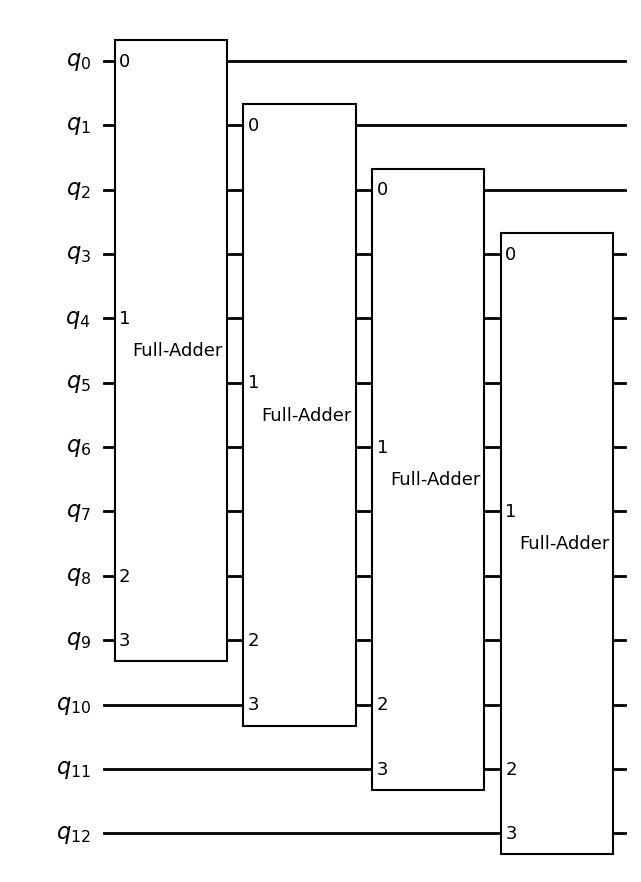

In [36]:
# Sumador de 4 bits usando 4 FA.
# 13 qubits de entrada.
full_adder_4 = QuantumCircuit(13, name="Full-Adder-4")

# Índices de los qubits.
A = [0, 1, 2, 3]
B = [4, 5, 6, 7]
S = [8, 9, 10, 11] # Salidas.
cin = S[0]
cout = [9, 10, 11, 12]
final_cout = cout[3] # Último cout.

# Aplicación del primer FA (LSQ - Least Significant Qubit).
full_adder_4.append(full_adder, [A[0], B[0], S[0], cout[0]])

# Aplicación del segundo FA.
full_adder_4.append(full_adder, [A[1], B[1], S[1], cout[1]])

# Aplicación del tercer FA.
full_adder_4.append(full_adder, [A[2], B[2], S[2], cout[2]])

# Aplicación del cuarto FA. (MSB - Most Significant Qubit).
full_adder_4.append(full_adder, [A[3], B[3], S[3], cout[3]])

full_adder_4.draw(output='mpl', style='bw')

Se añaden al circuito las mediciones que permiten realizar la simulación. Se utilizan 14 bits clásicos para realizar las mediciones, permitiendo así medir cada una de las entradas y salidas (hay un bit adicional, con respecto al número de qubits, debido a que, en q8, es igual de importante medir Cin como S0).

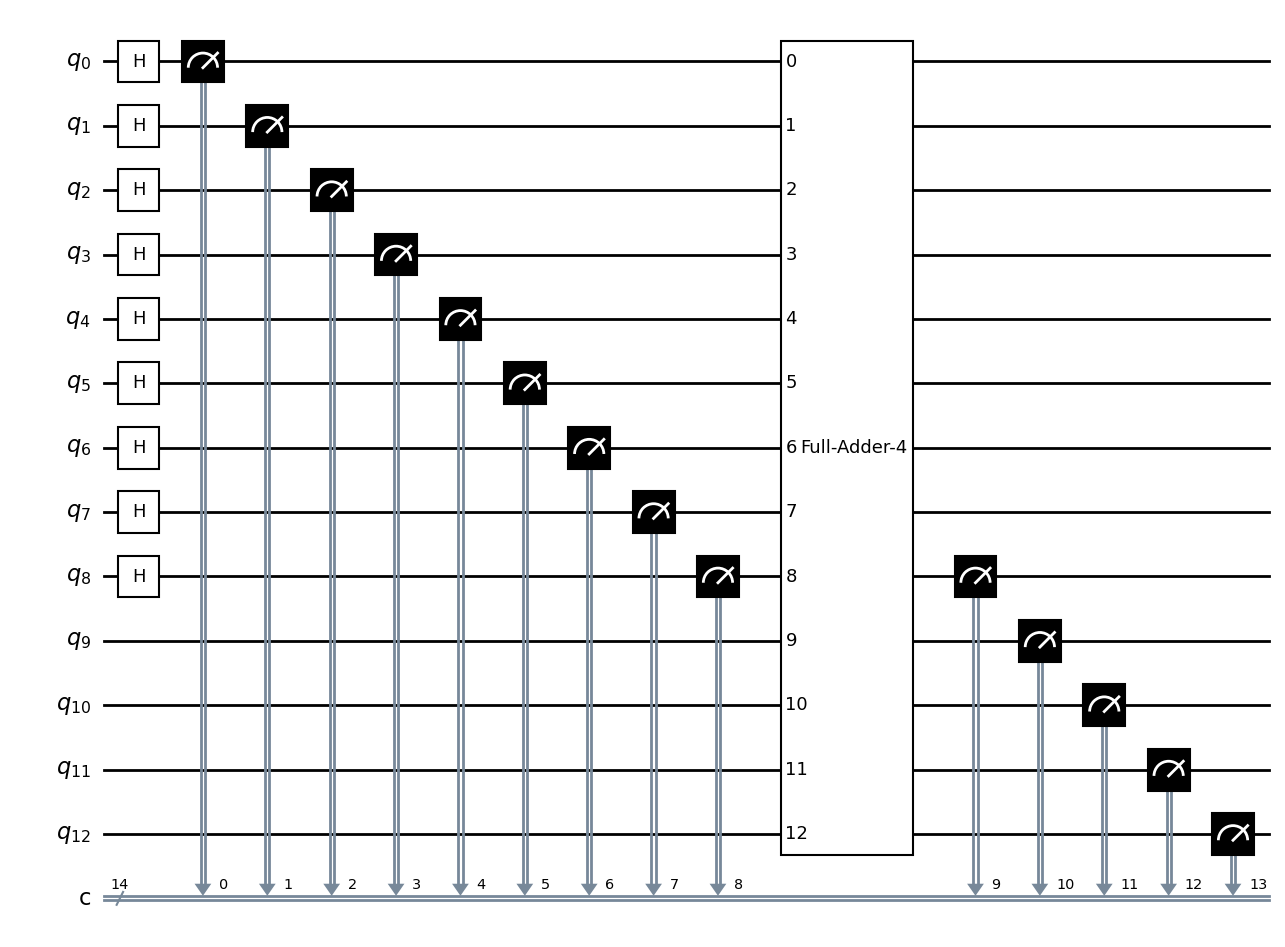

In [57]:
# Se utilizan 14 bits clásicos para 
measured_quantum_circuit = QuantumCircuit(13, 14)

# Entradas en superposición.
measured_quantum_circuit.h([0, 1, 2, 3, 4, 5, 6, 7, 8])

next_measurement_qubit = 0

# Medición de las entradas (A, B y Cin) en bit 0, 1 y 2, respectivamente.
for qubit_number in range(9):
    measured_quantum_circuit.measure(qubit_number, next_measurement_qubit)
    next_measurement_qubit += 1

# Aplicación de la compuerta Full-Adder.
measured_quantum_circuit.append(full_adder_4, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

for qubit_number in S:
    measured_quantum_circuit.measure(qubit_number, next_measurement_qubit)
    next_measurement_qubit += 1

measured_quantum_circuit.measure(final_cout, next_measurement_qubit)

# Comprobación gráfica del circuito
measured_quantum_circuit.draw(output='mpl', style='bw')

Se realiza la simulación y se presentan los resultados mediante un histograma:

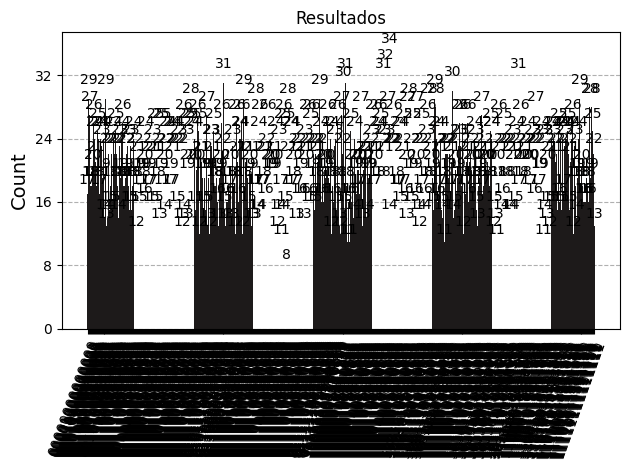

In [59]:
simulator = AerSimulator()
transpiled = transpile(measured_quantum_circuit, simulator)
job = simulator.run(transpiled, shots=10240)
results = job.result()
counts = results.get_counts(transpiled)

plot_histogram(counts, title="Resultados", color="#1D1A1A")

Similar al caso del FA, un histograma no es apropiado para mostrar los resultados de la simulación, mucho menos dada la gran cantidad posibilidades que abarca un FA4. Se intentó ajustar sus parámetros, ccon la intención de hacerlo más legible, sin embargo, es una tarea imposible. Además, la lectura de los bitstring no es sencilla. Por consiguiente, aunque resulte totalmente ilegible, este solo se incluye para cumplir con las pautas del informe; no obstante, la comprobación de que el algoritmo funciona correctamente se presenta en formato de tabla. Esta, en cada fila, muestra cada una de las posibles combinaciones. Adicionalmente, para cada combinación, se calcula su valor esperado y se corrobora con el valor obtenido.

In [39]:
# Número de bits de los operandos.
N_QUBITS = 4

"""
Si se quiere probar una configuraciń específica, puede hacerse colocaándolas
de la siguiente forma:

counts = {
    '00000000000000': 0,
    '00001100000000': 1024, 
    ...,
}
"""

# Anchos de columnas.
W_QUBITS = max(11, N_QUBITS * 3 - 1)  # Para A, B y S.
W_COUNT = 12
W_CHECK = 16

# Ancho total: 5 columnas de bits + count + check + separadores.
TOTAL_WIDTH = 5 * W_QUBITS + W_COUNT + W_CHECK + 14 + 8

def parse(substring, n):
    """
    Extracción de los qubits del bitstring, siguiendo, de acuerdo a cómo se plantearon
    las mediciones, el siguiente formato: [Cout][SN..S0][Cin][BN..B0][AN..A0]
    
    Debido a que los bits en el string están como [Xn-1...X0], hay que invertirlos para obtener [X0...Xn-1].
    """
    i = 0
    parsed_cout = int(substring[i]); i += 1
    parsed_s = [int(substring[i+n-1-j]) for j in range(n)]; i += n  # Invertido: se guarda S0 primero.
    parsed_cin = int(substring[i]); i += 1
    parsed_b = [int(substring[i+n-1-j]) for j in range(n)]; i += n  # Invertido: se guarda B0 primero.
    parsed_a = [int(substring[i+n-1-j]) for j in range(n)]          # Invertido: se guarda A0 primero.
    return parsed_a, parsed_b, parsed_cin, parsed_s, parsed_cout

# Calcular suma esperada
def expected(A, B, cin, n):
    """
    Usando operadores de corrimiento de bits, se calcula la suma esperada.
    """
    a = sum(A[i] << i for i in range(n))
    b = sum(B[i] << i for i in range(n))
    total = a + b + cin
    expected_s = [(total >> i) & 1 for i in range(n)]
    expected_cout = (total >> n) & 1
    return expected_s, expected_cout

# Título de la tabla.
print_separator(TOTAL_WIDTH)
print(f"|{'Tabla de Verdad - Sumador de ' + str(N_QUBITS) + ' bits':^{TOTAL_WIDTH - 2}}|")
print_separator(TOTAL_WIDTH)

# Encabezados.
headers = [f"A{N_QUBITS-1}...A0", f"B{N_QUBITS-1}...B0", "Cin", f"S{N_QUBITS-1}...S0", "Cout"]
print(f"| {headers[0]:^{W_QUBITS}} | {headers[1]:^{W_QUBITS}} | {headers[2]:^{W_QUBITS}} | {headers[3]:^{W_QUBITS}} | {headers[4]:^{W_QUBITS}} | {'Frecuencia':^{W_COUNT}} | {'¿Correcto?':^{W_CHECK}} |")
print_separator(TOTAL_WIDTH)

# Generación de cada fila.
for bitstring, count in sorted(counts.items()):
    parsed_a, parsed_b, parsed_cin, parsed_s, parsed_cout = parse(bitstring, N_QUBITS)
    expected_s, expected_cout = expected(parsed_a, parsed_b, parsed_cin, N_QUBITS)
    
    ok = "SÍ" if parsed_s == expected_s and parsed_cout == expected_cout else "NO"
    
    # Se muestran los bits de mayor a menor índice.
    a_str = ' '.join(str(parsed_a[i]) for i in range(N_QUBITS-1, -1, -1))
    b_str = ' '.join(str(parsed_b[i]) for i in range(N_QUBITS-1, -1, -1))
    s_str = ' '.join(str(parsed_s[i]) for i in range(N_QUBITS-1, -1, -1))
    
    print(f"| {a_str:^{W_QUBITS}} | {b_str:^{W_QUBITS}} | {parsed_cin:^{W_QUBITS}} | {s_str:^{W_QUBITS}} | {parsed_cout:^{W_QUBITS}} | {count:^{W_COUNT}} | {ok:^{W_CHECK}} |")

print_separator(TOTAL_WIDTH)

# Impresión de las estadísticas.
total = sum(counts.values())
correct = sum(count for s, count in counts.items() 
            if parse(s, N_QUBITS)[3:] == expected(*parse(s, N_QUBITS)[:3], N_QUBITS))

print(f"\nTotal mediciones: {total}")
print(f"Configuraciones únicas: {len(counts)}")
print(f"Precisión: {100 * correct / total:.2f}%" if total > 0 else "N/A")

|-------------------------------------------------------------------------------------------------------|
|                                  Tabla de Verdad - Sumador de 4 bits                                  |
|-------------------------------------------------------------------------------------------------------|
|   A3...A0   |   B3...B0   |     Cin     |   S3...S0   |    Cout     |  Frecuencia  |    ¿Correcto?    |
|-------------------------------------------------------------------------------------------------------|
|   0 0 0 0   |   0 0 0 0   |      0      |   0 0 0 0   |      0      |      21      |        SÍ        |
|   0 0 0 1   |   0 0 0 0   |      0      |   0 0 0 1   |      0      |      23      |        SÍ        |
|   0 0 0 0   |   0 0 0 1   |      0      |   0 0 0 1   |      0      |      21      |        SÍ        |
|   0 0 0 0   |   0 0 0 0   |      1      |   0 0 0 1   |      0      |      16      |        SÍ        |
|   0 0 1 0   |   0 0 0 0   |      0      |   

Como puede observarse en las estadísticas de la tabla, la precisión del circuito es del 100 %, lo que indica que el FA4 fue implementado correctamente.

## B) Deutsch-Jozsa - Función Constante Igual a 1

Este inciso corresponde al ejemplo 1 del ejercicio 1 del TP de paralelismo, el cual se muestra a continuación:

![ejemploNro1.png](images/ejemploNro1.png)

Como primer paso, se construye el circuito de Deutsch-Jozsa para funciones de _N_ entradas y un resultado. Este se plantea de forma que sea reutilizable, ya que los demás incisos también lo requieren.

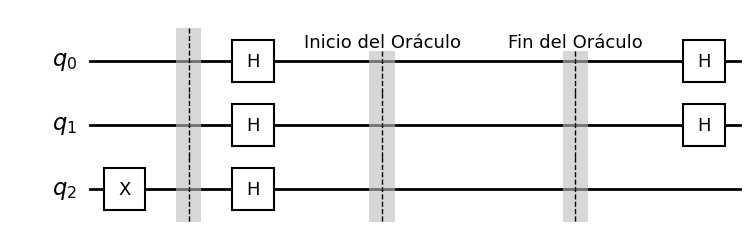

In [ ]:
def deutsch_jozsa(n_qubits, oracle_function=None):
    """
    Retorna un circuito Deutsch-Jozsa de N qubits.
    
    Args:
        n_qubits: Número de qubits de entrada (con 1 qubit auxiliar).
        oracle_function: Función que recibe el circuito y aplica el oráculo
    """
    
    deutsch_jozsa = QuantumCircuit(n_qubits, name="Deutsch-Jozsa")
    
    # Aplicación de la compuerta X al último qubit, puesto a que,
    # por defecto, en Quiskit todos los qubits comienzan en 0 y, el
    # algoritmo, establece que el qubit auxiliar debe comenzar en 1.
    deutsch_jozsa.x(n_qubits - 1)
    
    # Separación mediante barrera para que quede más estético y ordenado.
    deutsch_jozsa.barrier()
    
    # Aplicación de Hadamards a las entradas y al qubit auxiliar.
    deutsch_jozsa.h(range(n_qubits))
    deutsch_jozsa.barrier(label="Inicio del Oráculo")
    
    # De existir, se aplica el oráculo.
    if oracle_function:
        oracle_function(deutsch_jozsa, n_qubits)
    
    deutsch_jozsa.barrier(label="Fin del Oráculo")
    
    # Aplicación de Hadamards a los qubits de entradas.
    deutsch_jozsa.h(range(n_qubits - 1))
    
    return deutsch_jozsa

circuit = deutsch_jozsa(3)
circuit.draw(output='mpl', style='bw')

Con el circuito de Deutsch-Jozsa planteado, se construye el circuito de la función (oráculo en el contexto del algoritmo) del enunciado:

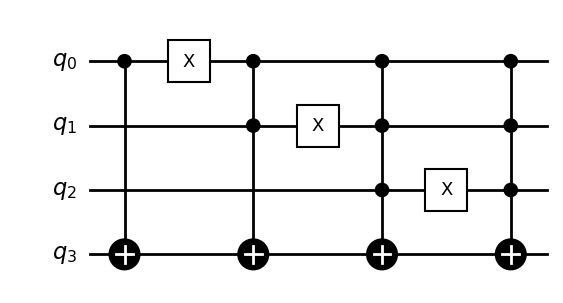

In [41]:
def oraculo(quantum_circuit, number_of_qubits):
    
    # Número de qubits que pueden acceder a través
    # los índices. Variable definida para no restar
    # constantemente uno.
    accesible_qubits = number_of_qubits - 1
    
    quantum_circuit.cx(0, accesible_qubits)
    quantum_circuit.x(0)
    quantum_circuit.ccx(0, 1, accesible_qubits)
    quantum_circuit.x(1)
    # Todos los qubits excepto el último como controles
    quantum_circuit.mcx(list(range(accesible_qubits)), accesible_qubits)
    quantum_circuit.x(2)
    quantum_circuit.mcx(list(range(accesible_qubits)), accesible_qubits)
    
    return quantum_circuit
    

qc = QuantumCircuit(4)
oraculo(qc, 4).draw(output='mpl', style='bw')

El cual puede generalizarse para _N_ (con _N_ > 1) de la siguiente forma:

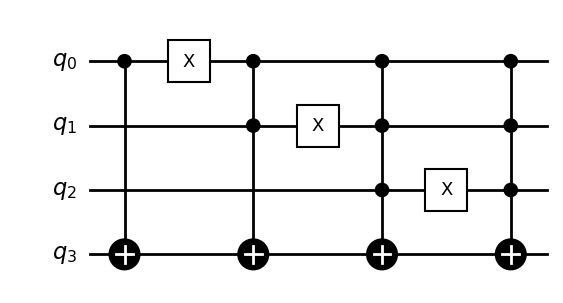

In [42]:
def oraculo(quantum_circuit, number_of_qubits):
    
    if (number_of_qubits < 2):
        return
    
    # Número de qubits que pueden acceder a través
    # los índices. Variable definida para no restar
    # constantemente uno.
    accesible_qubits = number_of_qubits - 1
    
    for qubit in range(accesible_qubits):
        quantum_circuit.mcx(list(range(qubit + 1)), accesible_qubits)
        quantum_circuit.x(qubit)
        
    quantum_circuit.mcx(list(range(accesible_qubits)), accesible_qubits)
    
    return quantum_circuit

number_of_qubits = 4
qc = QuantumCircuit(number_of_qubits)

oraculo(qc, number_of_qubits).draw(output='mpl', style='bw')

Aplicando el algoritmo de Deutsch-Jozsa al oráculo, se obtiene el siguiente circuito:

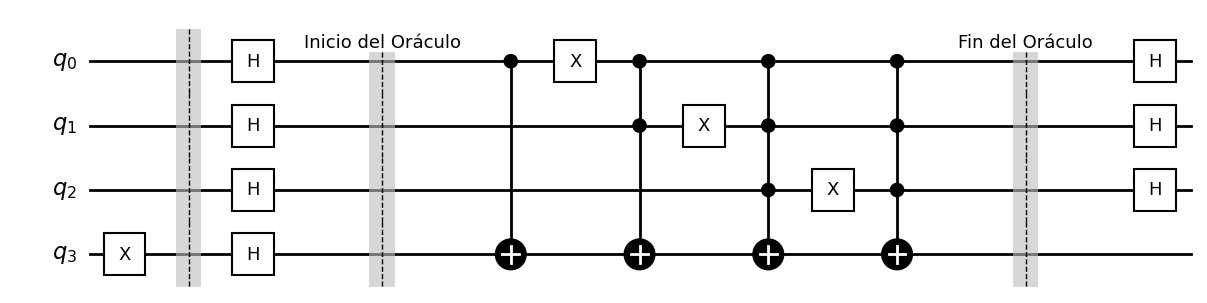

In [43]:
number_of_qubits = 4

result = deutsch_jozsa(number_of_qubits, oraculo)
result.draw(output='mpl', style='bw')

Se le añaden las mediciones correspondientes para realizar la simulación. En Deutsch-Jozsa, no se debe medir el qubit auxiliar, ya que no aporta información sobre si la función es constante o balanceada. Solo importan los qubits de entrada.

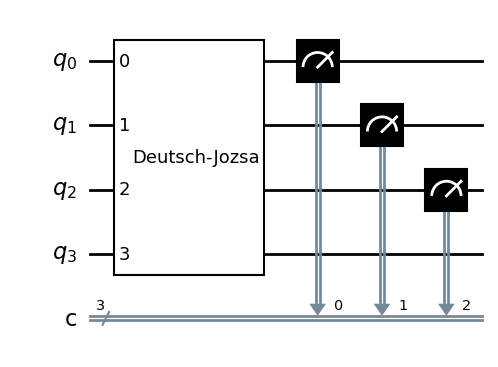

In [44]:
measured_quantum_circuit = QuantumCircuit(number_of_qubits, number_of_qubits - 1)

measured_quantum_circuit.append(result, list(range(number_of_qubits)))

for i in range(number_of_qubits - 1): # -1 ya que no se quiere medir el auxiliar.
    measured_quantum_circuit.measure(i, i)
    
measured_quantum_circuit.draw(output='mpl', style='bw')

A continuación, con las mediciones ya colocadas, se realiza la simulación:

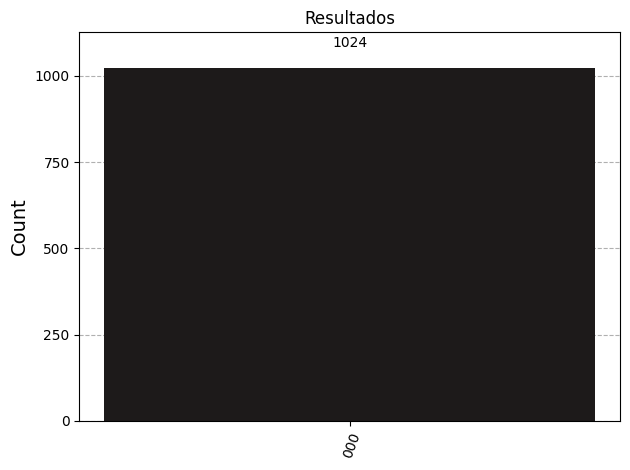

In [45]:
simulator = AerSimulator()
transpiled = transpile(measured_quantum_circuit, simulator)
job = simulator.run(transpiled, shots=1024)
results = job.result()
counts = results.get_counts(transpiled)

plot_histogram(counts, title="Resultados", color="#1D1A1A")

El algoritmo de Deutsch-Jozsa establece que:

- Si la función es constante, toda la probabilidad colapsa en un solo estado básico: el |000⟩.
- Por otro lado, si la función es balanceada, la probabilidad se reparte entre cualquier combinación de estados básicos **exceptuando** el |000⟩.

Por consiguiente, como todas las mediciones colapsan únicamente en el estado básico |000⟩, queda demostrado que la función es constante.

## Deutsch-Jozsa - Función Balanceada

Este inciso corresponde al ejemplo 3 del ejercicio 1 del TP de paralelismo, el cual se muestra a continuación:

![ejemploNro3.png](images/ejemploNro3.png)

Debido a que previamente ya se planteó el algoritmo de Deutsch-Jozsa, solo se requiere plantear el oráculo de la función:

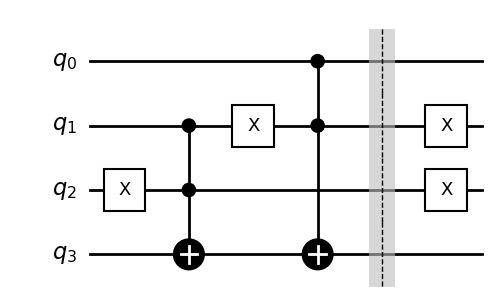

In [46]:
def oraculo(quantum_circuit, number_of_qubits):
    
    # Número de qubits que pueden acceder a través
    # los índices. Variable definida para no restar
    # constantemente uno.
    accesible_qubits = number_of_qubits - 1
    
    quantum_circuit.x(2)
    quantum_circuit.ccx(2, 1, accesible_qubits)
    quantum_circuit.x(1)
    quantum_circuit.ccx(1, 0, accesible_qubits)
    
    # Se coloca una barrera para que Qiskit no reordene automáticamente
    # el circuito y, de esta forma, quede como en la teoría.
    quantum_circuit.barrier()
    
    quantum_circuit.x(2)
    quantum_circuit.x(1)
    
    return quantum_circuit
    

qc = QuantumCircuit(4)
oraculo(qc, 4).draw(output='mpl', style='bw')

El cual puede generalizarse para _N_ (con _N_ > 1) qubits como:

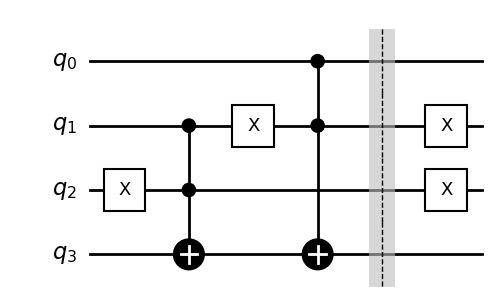

In [ ]:
def oraculo(quantum_circuit, number_of_qubits):
    
    if (number_of_qubits < 2):
        return
    
    # Número de qubits que pueden acceder a través
    # los índices. Variable definida para no restar
    # constantemente uno.
    accesible_qubits = number_of_qubits - 1
    
    for qubit in range(accesible_qubits - 1, 0, -1):
        quantum_circuit.x(qubit)
        quantum_circuit.ccx(qubit, qubit - 1, accesible_qubits)
    
    # Barrera para evitar el reordenamiento automático.
    quantum_circuit.barrier()
    
    for qubit in range(accesible_qubits - 1, 0, -1):
        quantum_circuit.x(qubit)
    
    return quantum_circuit
    

number_of_qubits = 4
qc = QuantumCircuit(number_of_qubits)
oraculo(qc, number_of_qubits).draw(output='mpl', style='bw')

Aplicando el algoritmo de Deutsch-Jozsa al oráculo planteado, se obtiene el siguiente circuito:

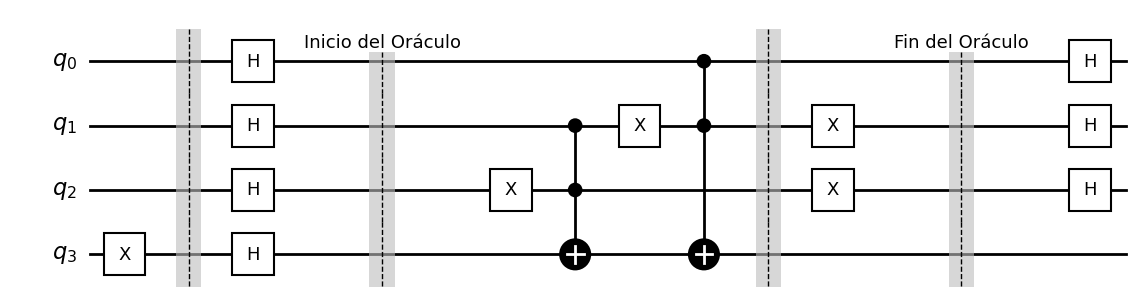

In [48]:
number_of_qubits = 4

result = deutsch_jozsa(number_of_qubits, oraculo)
result.draw(output='mpl', style='bw')

Se añaden las mediciones correspondientes para realizar la simulación:

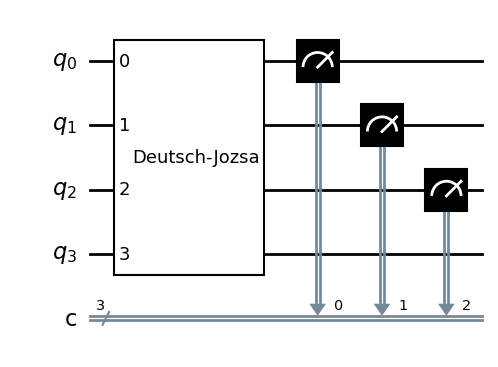

In [49]:
measured_quantum_circuit = QuantumCircuit(number_of_qubits, number_of_qubits - 1)

measured_quantum_circuit.append(result, list(range(number_of_qubits)))

for i in range(number_of_qubits - 1): # -1 ya que no se quiere medir el auxiliar.
    measured_quantum_circuit.measure(i, i)
    
measured_quantum_circuit.draw(output='mpl', style='bw')

Con las mediciones agregadas, se realiza la simulación y se presentan los resultados en formato de histograma:

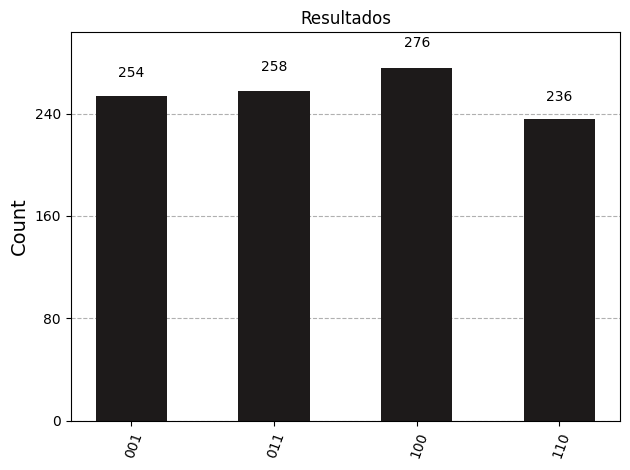

In [50]:
simulator = AerSimulator()
transpiled = transpile(measured_quantum_circuit, simulator)
job = simulator.run(transpiled, shots=1024)
results = job.result()
counts = results.get_counts(transpiled)

plot_histogram(counts, title="Resultados", color="#1D1A1A")

El algoritmo de Deutsch-Jozsa establece que:

- Si la función es constante, toda la probabilidad colapsa en un solo estado básico: el |000⟩.
- Por otro lado, si la función es balanceada, la probabilidad se reparte entre cualquier combinación de estados básicos **exceptuando** el |000⟩.

Como puede obversarse, los resultados presentados coinciden con la segunda definición. Por consiguiente, queda demostrado que la función es balanceada.

## D) Deutsch-Jozsa - Función No Balanceada Ni Constante

Este inciso corresponde al ejemplo 4 del ejercicio 1 del TP de paralelismo, el cual se muestra a continuación:

![ejemploNro4.png](images/ejemploNro4.png)

Debido a que previamente ya se planteó el algoritmo de Deutsch-Jozsa, solo se requiere plantear el oráculo de la función:

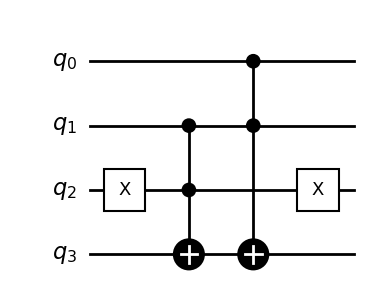

In [ ]:
def oraculo(quantum_circuit, number_of_qubits):
    
    # Número de qubits que se pueden acceder a través los índices.
    accesible_qubits = number_of_qubits - 1
    
    quantum_circuit.x(2)
    quantum_circuit.ccx(2, 1, accesible_qubits)
    quantum_circuit.ccx(1, 0, accesible_qubits)
    
    quantum_circuit.x(2)
    
    return quantum_circuit
    

qc = QuantumCircuit(4)
oraculo(qc, 4).draw(output='mpl', style='bw')

El cual puede generalizarse para _N_ qubits (con _N_ > 1) de la siguiente manera:

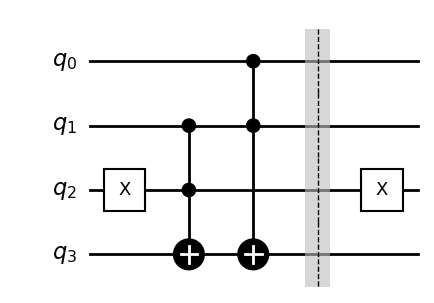

In [ ]:
def oraculo(quantum_circuit, number_of_qubits):
    
    if (number_of_qubits < 2):
        return
    
    # Número de qubits que pueden acceder a través los índices.
    accesible_qubits = number_of_qubits - 1
    
    quantum_circuit.x(accesible_qubits - 1)
    
    for qubit in range(accesible_qubits - 1, 0, -1):
        quantum_circuit.ccx(qubit, qubit - 1, accesible_qubits)
    
    # Se coloca una barrera para evitar el reordenamiento
    # automático de Qiskit.
    quantum_circuit.barrier()
    
    quantum_circuit.x(accesible_qubits - 1)
    
    return quantum_circuit
    
number_of_qubits = 4

qc = QuantumCircuit(number_of_qubits)
oraculo(qc, number_of_qubits).draw(output='mpl', style='bw')

Aplicando el algoritmo de Deutsch-Jozsa al oráculo, se obtiene el siguiente circuito:

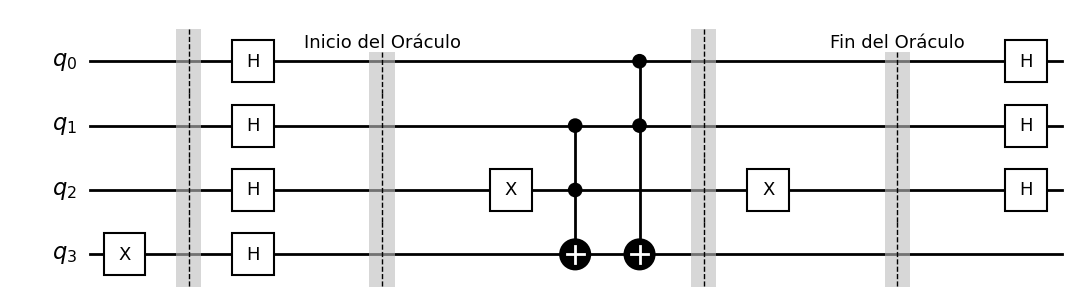

In [53]:
number_of_qubits = 4

result = deutsch_jozsa(number_of_qubits, oraculo)
result.draw(output='mpl', style='bw')

A continuación, se añaden las mediciones necesarias para realizar la simulación:

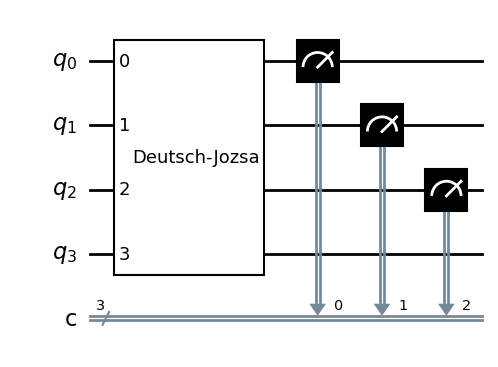

In [54]:
measured_quantum_circuit = QuantumCircuit(number_of_qubits, number_of_qubits - 1)

measured_quantum_circuit.append(result, list(range(number_of_qubits)))

for i in range(number_of_qubits - 1): # -1 ya que no se quiere medir el auxiliar.
    measured_quantum_circuit.measure(i, i)

measured_quantum_circuit.draw(output='mpl', style='bw')

Con las mediciones agregadas, se realiza la simulación y se presentan los resultados en forma de histograma:

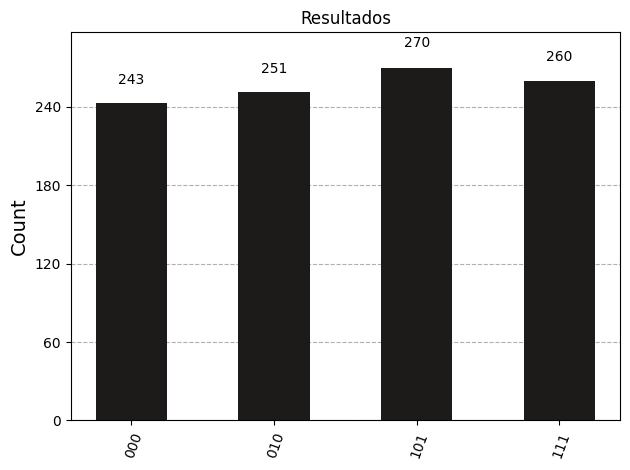

In [55]:
simulator = AerSimulator()
transpiled = transpile(measured_quantum_circuit, simulator)
job = simulator.run(transpiled, shots=1024)
results = job.result()
counts = results.get_counts(transpiled)

plot_histogram(counts, title="Resultados", color="#1D1A1A")

El algoritmo de Deutsch-Jozsa establece que:

- Si la función es constante, toda la probabilidad colapsa en un solo estado básico: el |000⟩.
- Por otro lado, si la función es balanceada, la probabilidad se reparte entre cualquier combinación de estados básicos **exceptuando** el |000⟩.

Como puede observarse, la función no cumple con los prerequisitos del algoritmo. Los estados básicos que se miden son variados e incluyen al |000⟩. Por consiguiente, queda demostrado que esta no es balanceada ni constante.